In [1]:
import torch
import os
import random
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 64,
        'rnn_layers': 5,
        'readout_layers': 1,
        'cell_type': 'lstm',
        'dim_red': 10,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5,
        'testing': False,
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


In [2]:
# Fix cuda memory issue
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [13:25<00:00,  1.23it/s]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


# PCA

Let's check how the two classes separate in the first three PC when doing dimensionality reduction to 10

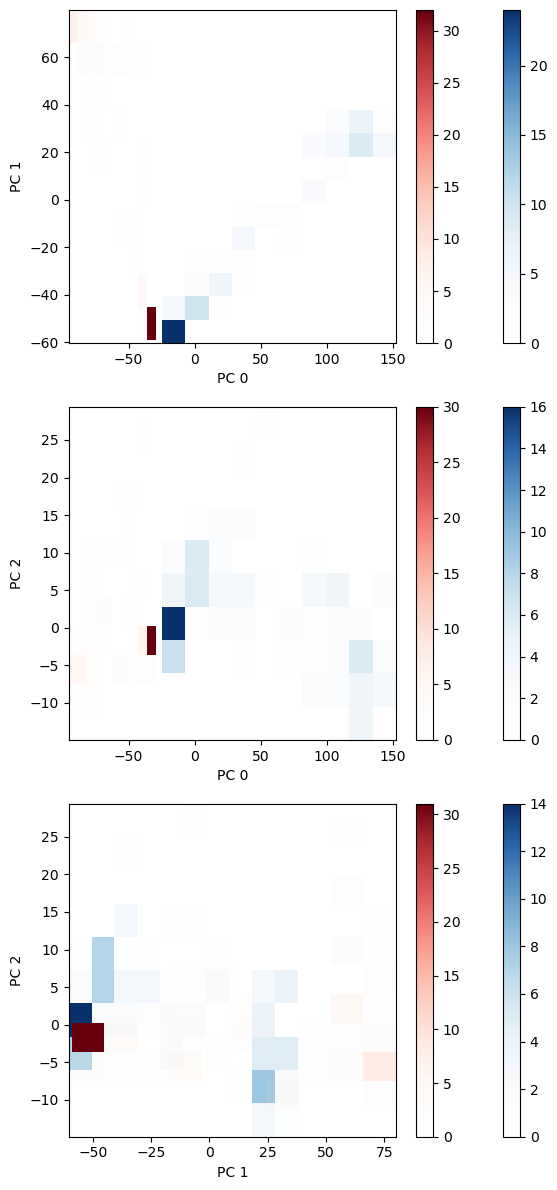

In [4]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

train_X, val_X, train_y, val_y = train_test_split(states.inputs, states.targets, test_size=0.2, random_state=seed)

pca = PCA(n_components=10)
train_X_red = pca.fit_transform(train_X[:,-1,:])
val_X_red = pca.transform(val_X[:,-1,:])

idx0 = val_y == 0
idx1 = val_y == 1
label_0 = val_X_red[idx0]
label_1 = val_X_red[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Calculate min and max values for each PC
pc0_min, pc0_max = min(val_X_red[:, 0]), max(val_X_red[:, 0])
pc1_min, pc1_max = min(val_X_red[:, 1]), max(val_X_red[:, 1])
pc2_min, pc2_max = min(val_X_red[:, 2]), max(val_X_red[:, 2])

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 1], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 1], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')
axs[0].set_xlim(pc0_min, pc0_max)
axs[0].set_ylim(pc1_min, pc1_max)
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 2')
axs[1].set_xlim(pc0_min, pc0_max)
axs[1].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 1], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 1], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 1')
axs[2].set_ylabel('PC 2')
axs[2].set_xlim(pc1_min, pc1_max)
axs[2].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for label_1 and label_0 data
df_label_0 = pd.DataFrame(label_0[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])
df_label_1 = pd.DataFrame(label_1[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])

# Add a column to indicate the label
df_label_0['label'] = 'Label 0'
df_label_1['label'] = 'Label 1'

# Concatenate the dataframes
df = pd.concat([df_label_0, df_label_1])

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='PC0', y='PC1', z='PC2', color='label')

# Show the plot
fig.show()

There is a strong separation in PC0. Is it showing a linear attractor?

Let's plot some trajectories as well

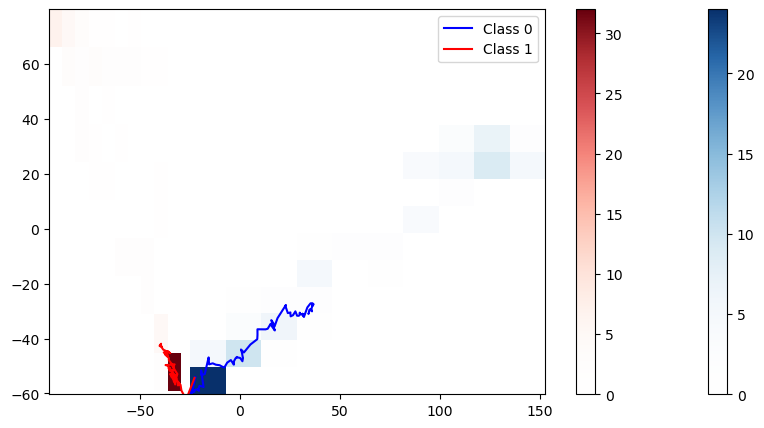

In [6]:
from einops import rearrange

val_proj20 = val_X_red[~val_y.astype(bool)]
val_proj21 = val_X_red[val_y.astype(bool)]

fig, ax = plt.subplots(figsize=(10, 5))

hist0 = ax.hist2d(val_proj20[:,0], val_proj20[:,1], bins=10, cmap=fading_blue)
hist1 = ax.hist2d(val_proj21[:,0], val_proj21[:,1], bins=10, cmap=fading_red)
ax.set_xlim(pc0_min, pc0_max)
ax.set_ylim(pc1_min, pc1_max)

plt.colorbar(hist0[3], ax=ax)
plt.colorbar(hist1[3], ax=ax)

# add one full trajectory for each class
val_X_rearr = rearrange(val_X, 'b t f -> (b t) f')
val_X_redt = pca.transform(val_X_rearr)
val_X_redt = rearrange(val_X_redt, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=10)

traj0 = val_X_redt[1]
traj1 = val_X_redt[0]

ax.plot(traj0[:,0], traj0[:,1], c='blue', label='Class 0')
ax.plot(traj1[:,0], traj1[:,1], c='red', label='Class 1')

# Show the plot
plt.legend()
plt.show()

Average trajectories:

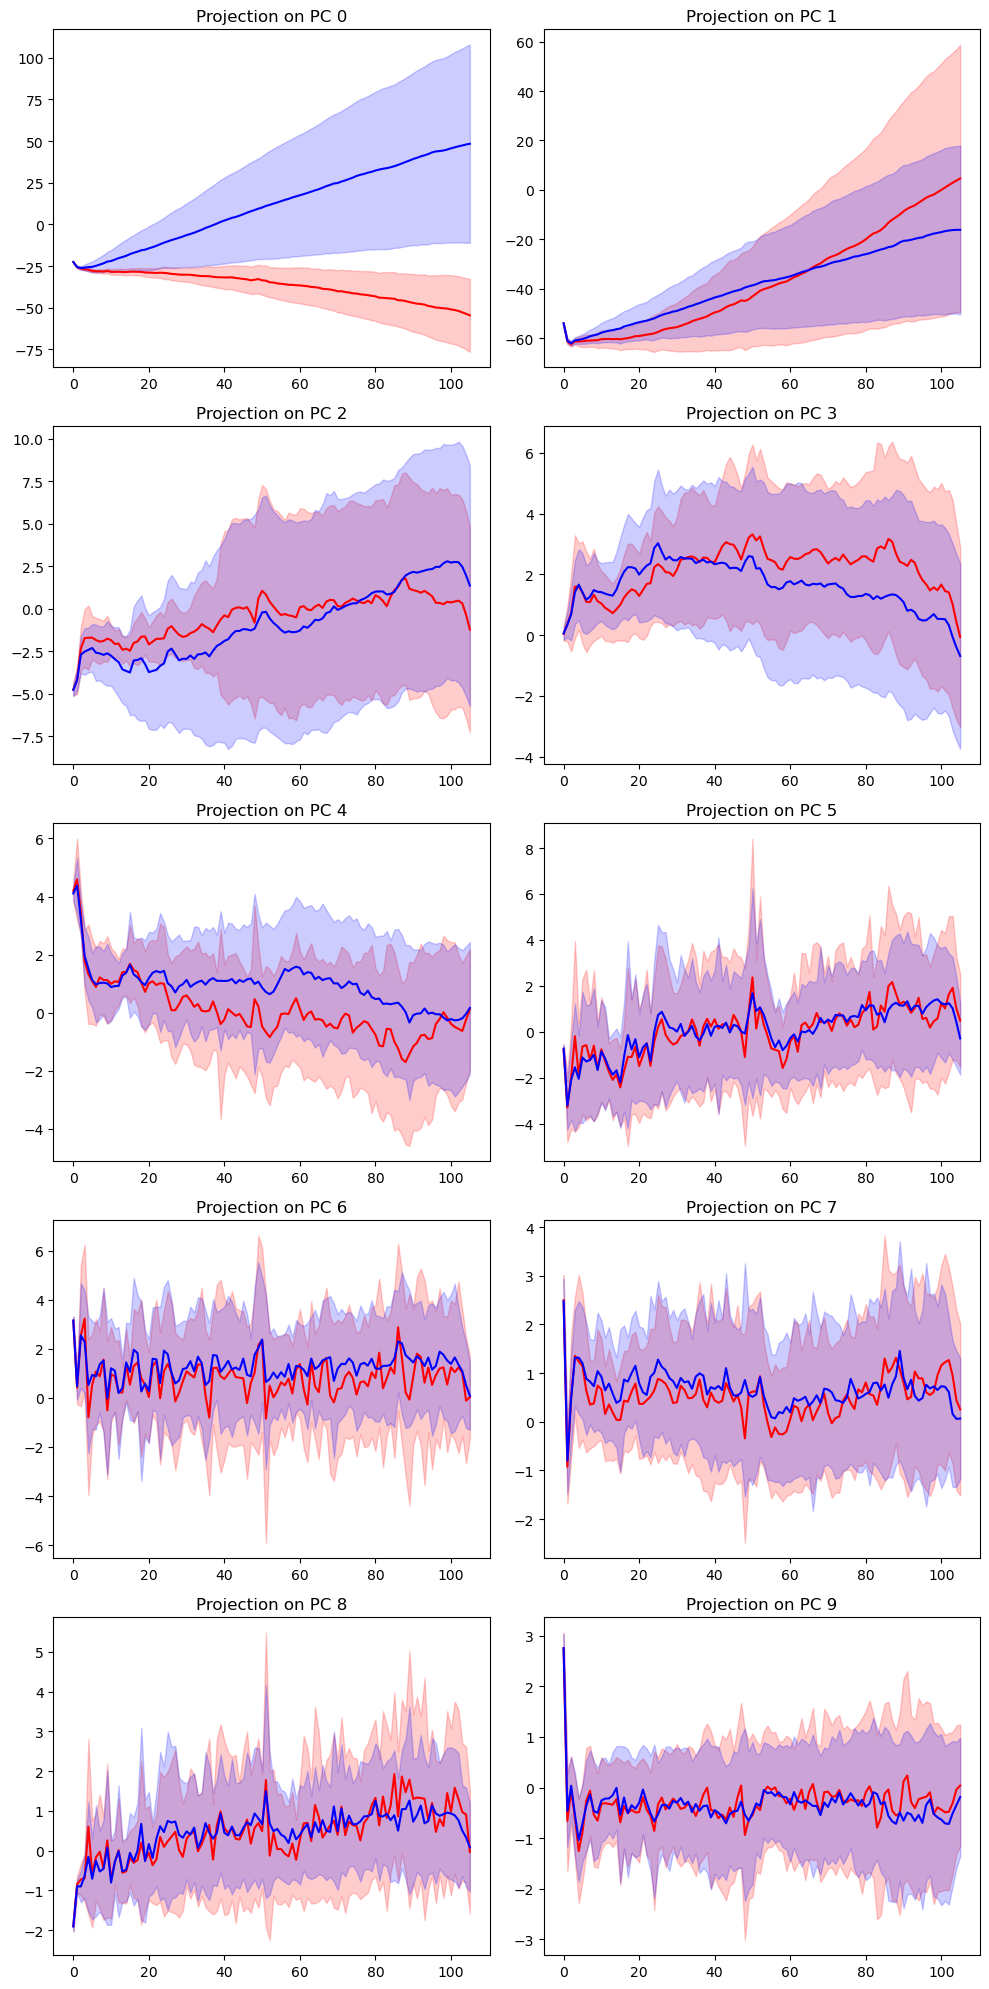

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj = val_X_redt[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i//2, i%2].plot(m, c='r', label="class 1")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2, i%2].plot(m_not, c='b', label="class 0")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# DMD

In [7]:
from koopman.dmd import DMD

dim_red = 10
method = 'PCA'

# compute local Koopman operator
dmd = DMD(train_X, k=dim_red, emb=method)

K0 = dmd.compute_KOP()

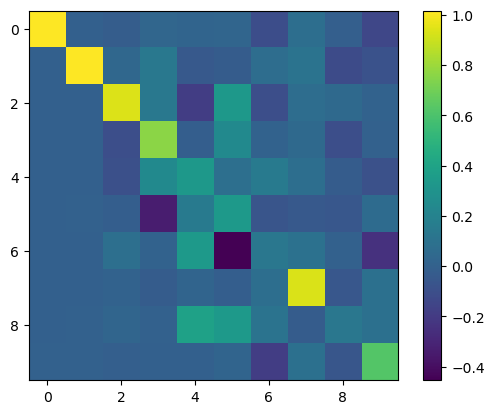

In [9]:
plt.imshow(K0)
plt.colorbar()

C:\Users\mgphy\AppData\Local\Temp\ipykernel_31868\1226691090.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



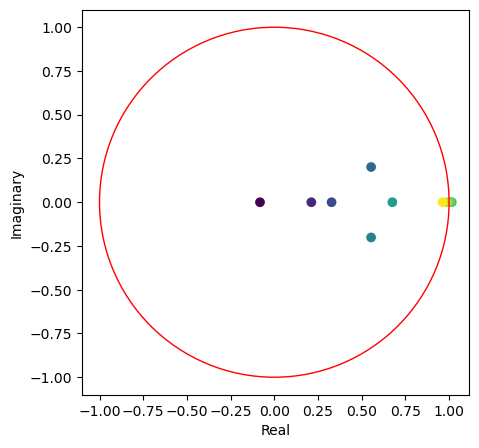

In [8]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

In [20]:
E

array([ 1.0155848 +0.j        ,  1.0079238 +0.j        ,
        0.9882818 +0.j        ,  0.96233225+0.j        ,
        0.67559016+0.j        ,  0.55391806-0.20121753j,
        0.55391806+0.20121753j,  0.32767493+0.j        ,
        0.21193367+0.j        , -0.08180273+0.j        ], dtype=complex64)

In [21]:
abs(E)

array([1.0155848 , 1.0079238 , 0.9882818 , 0.96233225, 0.67559016,
       0.5893333 , 0.5893333 , 0.32767493, 0.21193367, 0.08180273],
      dtype=float32)

Project states on first two eigenvectors (they are real)

In [9]:
v12 = V[:,0:2].real

# Calculate the projection
val_X_red2 = dmd.emb_engine.transform(val_X_rearr)
val_X_red2 = rearrange(val_X_red2, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=dim_red)
val_X_proj = np.dot(val_X_red2, v12)

In [23]:
val_X_proj.shape

(199, 106, 2)

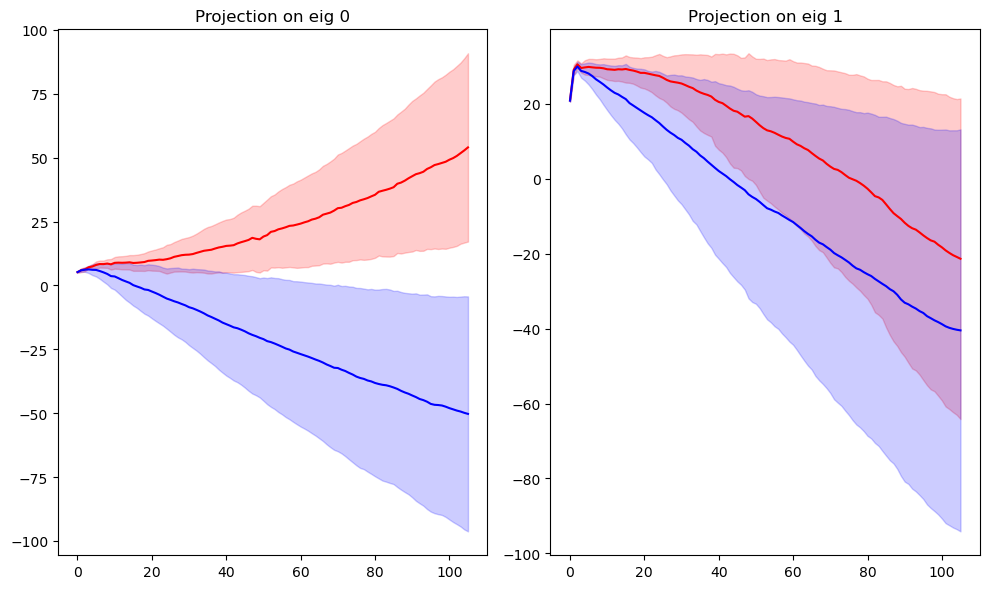

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i in range(2):
    val_proj = val_X_proj[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i%2].plot(m, c='r', label="class 1")
    axs[i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i%2].plot(m_not, c='b', label="class 0")
    axs[i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i%2].set_title(f'Projection on eig {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
v12

array([[-0.08478115, -0.01240422],
       [ 0.0290284 ,  0.2754092 ],
       [ 0.25890476,  0.7741073 ],
       [-0.03572986, -0.34988797],
       [-0.49956453,  0.41502035],
       [ 0.26238146,  0.09453747],
       [-0.7740483 , -0.11792774],
       [-0.02878   , -0.0650612 ],
       [-0.03925996, -0.05267242],
       [ 0.06109021, -0.01544988]], dtype=float32)

In [22]:
val_X.shape

(199, 106, 256)

In [23]:
val_X_red2.shape

(199, 106, 10)

Focus on two trajectories pushed forward in time with the Koopman operator

In [25]:
val_X_rec0 = np.empty_like(val_X_red2[0])
val_X_rec1 = np.empty_like(val_X_red2[1])

for n in range(val_X_red2.shape[1]):
    val_X_rec0[n] = np.dot(val_X_red2[0][0], K0**n)
    val_X_rec1[n] = np.dot(val_X_red2[1][0], K0**n)
    

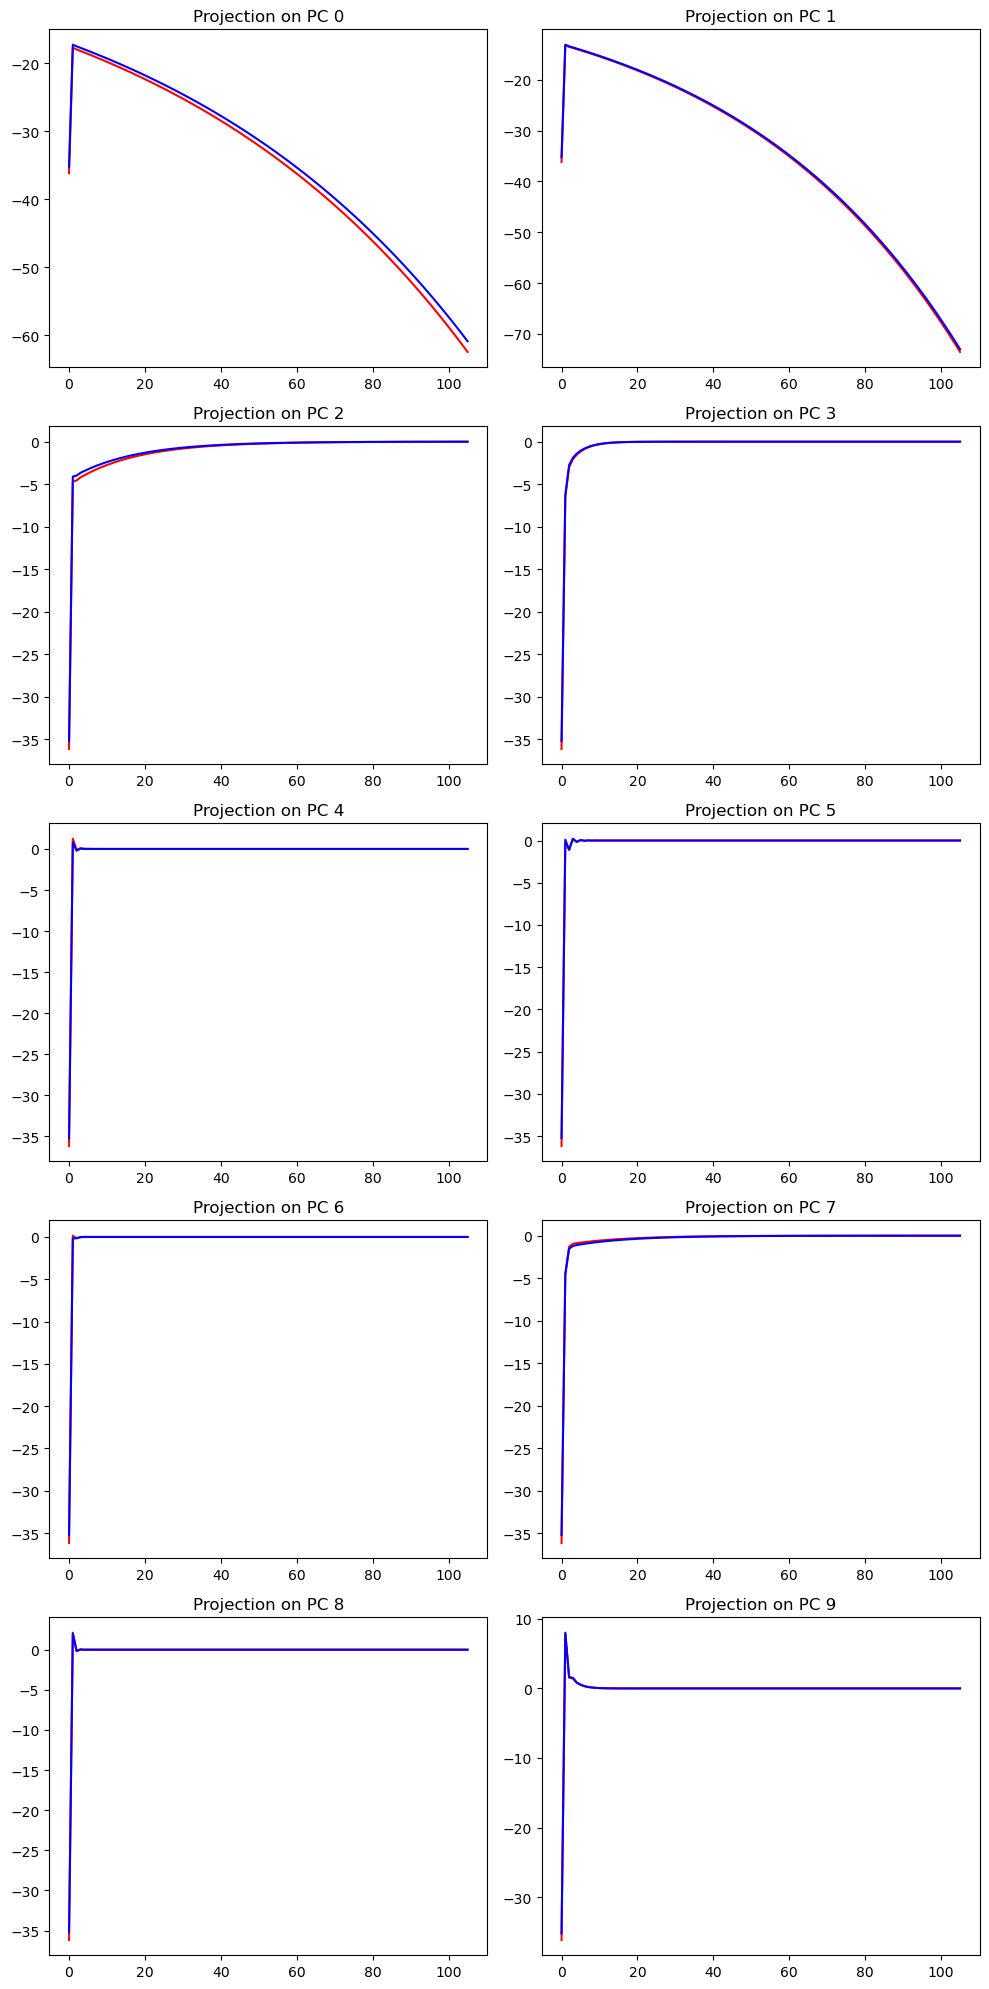

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj0 = val_X_rec0[:,i]
    val_proj1 = val_X_rec1[:,i]

    axs[i//2, i%2].plot(val_proj0, c='r', label="class 1")
    axs[i//2, i%2].plot(val_proj1, c='b', label="class 0")
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Relative error of reconstructed trajectories

In [28]:
# Reconstructing the whole trajectory from initial condition

val_X_rec = np.empty_like(val_X_red2)

for n in range(val_X_red2.shape[1]):
    val_X_rec[:,n,:] = np.dot(val_X_red2[:,0,:], K0**n)

val_X_rec = rearrange(val_X_rec, 'b t f -> (b t) f')
val_X_rec = dmd.emb_engine.inverse_transform(val_X_rec)
val_X_rec = rearrange(val_X_rec, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=320)

In [29]:
rel_e = [np.linalg.norm(val_X[:,t,:] - val_X_rec[:,t,:], ord='fro', axis=(0,1))**2 / 
         np.linalg.norm(val_X[:,t,:], ord='fro', axis=(0,1))**2 
         for t in range(val_X.shape[1])]

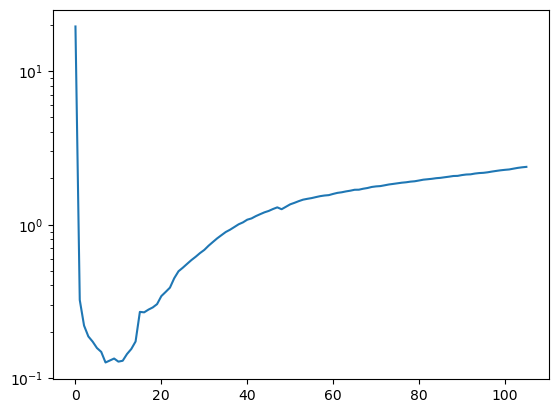

In [30]:
plt.plot(rel_e)
plt.yscale('log')
plt.show()

In [31]:
y = classifier.predict(val_X_rec[:,-1,:])
print(accuracy_score(val_y, y))

0.5376884422110553


In [104]:
# Reconstructing the whole trajectory step by step

val_X_rec = np.empty_like(val_X_red2)

val_X_rec[:,0,:] = val_X_red2[:,0,:]
for n in range(1, val_X_red2.shape[1]):
    val_X_rec[:,n,:] = np.dot(val_X_red2[:,n-1,:], K0)

val_X_rec = rearrange(val_X_rec, 'b t f -> (b t) f')
val_X_rec = dmd.emb_engine.inverse_transform(val_X_rec)
val_X_rec = rearrange(val_X_rec, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=256)

In [105]:
rel_e = [np.linalg.norm(val_X[:,t,:] - val_X_rec[:,t,:], ord='fro', axis=(0,1))**2 / 
         np.linalg.norm(val_X[:,t,:], ord='fro', axis=(0,1))**2 
         for t in range(val_X.shape[1])]

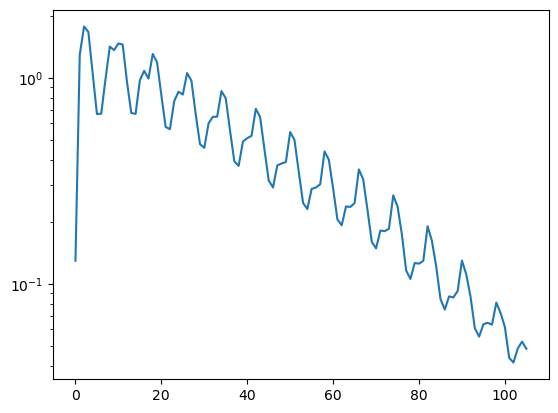

In [106]:
plt.plot(rel_e)
plt.yscale('log')
plt.show()

In [112]:
y = classifier.predict(val_X_rec[:,-1,:])
print(accuracy_score(val_y, y))

0.8844221105527639


Check if there's some correspondence between projected states and ground truth

In [28]:
val_X_proj.shape

(199, 106, 2)

In [10]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")

995it [00:18, 53.67it/s]


In [11]:
train_node_sums_gt, val_node_sums_gt, train_times_gt, val_times_gt = train_test_split(np.array(node_sums_gt), np.array(times_gt), test_size=0.2, random_state=seed)

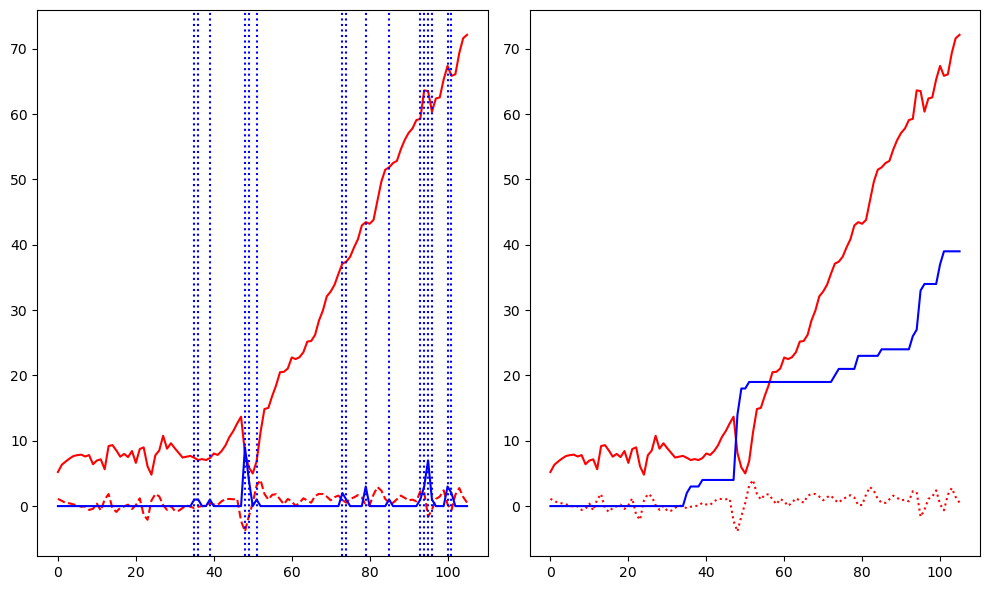

1.0


In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

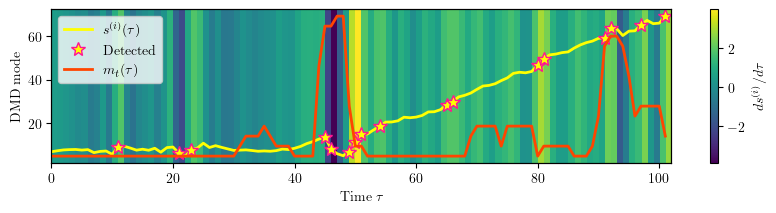

In [85]:
import matplotlib.pyplot as plt

# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

idx = 7

window_size = 5
threshold = np.mean(der_val_proj[idx]) + np.std(der_val_proj[idx])

fig, ax = plt.subplots(figsize=(10, 2))

# Plot the trajectory of val_proj
ax.plot(val_proj[idx][window_size//2:-window_size//2+1], c='yellow', label=r"$s^{(i)}(\tau)$", zorder=1, linewidth=2)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot the ground truth val_times_gt
filter = np.ones(window_size)
ground_truth_c = np.convolve(val_times_gt[idx], filter, mode='valid')
ax2.plot(ground_truth_c, c='orangered', label=r"$m_t(\tau)$", zorder=1, linewidth=2)

# Create a color scale using the derivative der_val_proj
derivative = der_val_proj[idx][window_size//2:-window_size//2+1]
detected = np.where(np.abs(derivative) > threshold)[0]
im = ax.imshow(derivative.reshape(1,-1), cmap='viridis', aspect='auto', alpha=1, zorder=0,
               extent=[0, derivative.shape[0], ax.get_ylim()[0], ax.get_ylim()[1]])

# Add detected points
det = np.zeros_like(ground_truth_c)
det[detected] = 1
ax.plot(np.where(det, val_proj[idx][window_size//2:-window_size//2+1], np.nan),
        '*', markerfacecolor='yellow', markeredgecolor='deeppink', markersize=10,
         label='Detected')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$ds^{(i)}/d\tau$')

# Add labels and legend
ax.set_xlabel(r'Time $\tau$')
ax.set_ylabel(r'DMD mode')

# Combine handles and labels from both axes
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

# Add a single legend
ax.legend(handles, labels)

# Hide the secondary y-axis
ax2.yaxis.set_visible(False)

# Show the plot
plt.show()

In [42]:
derivative.shape

(102,)

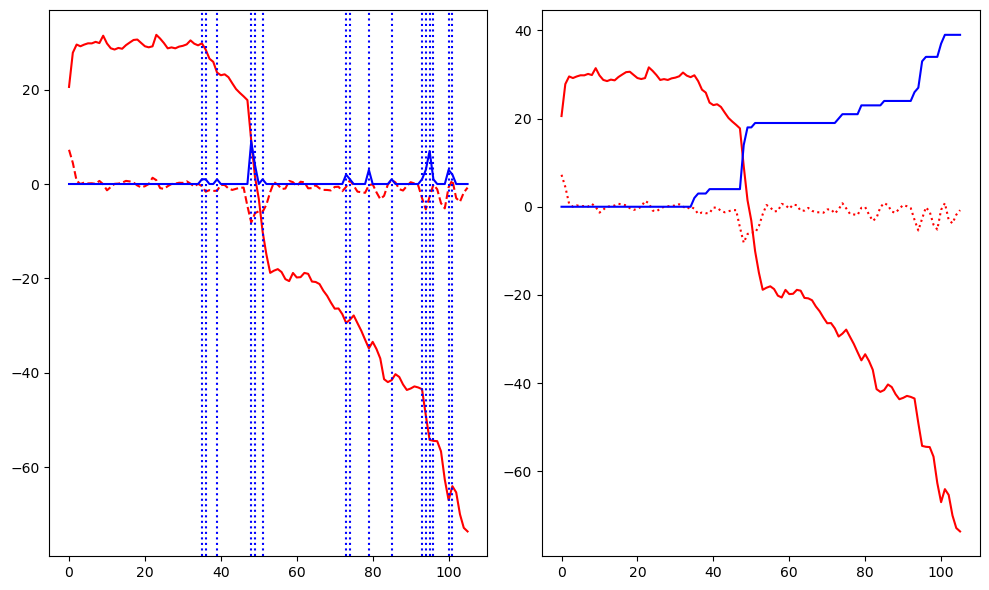

1.0


In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

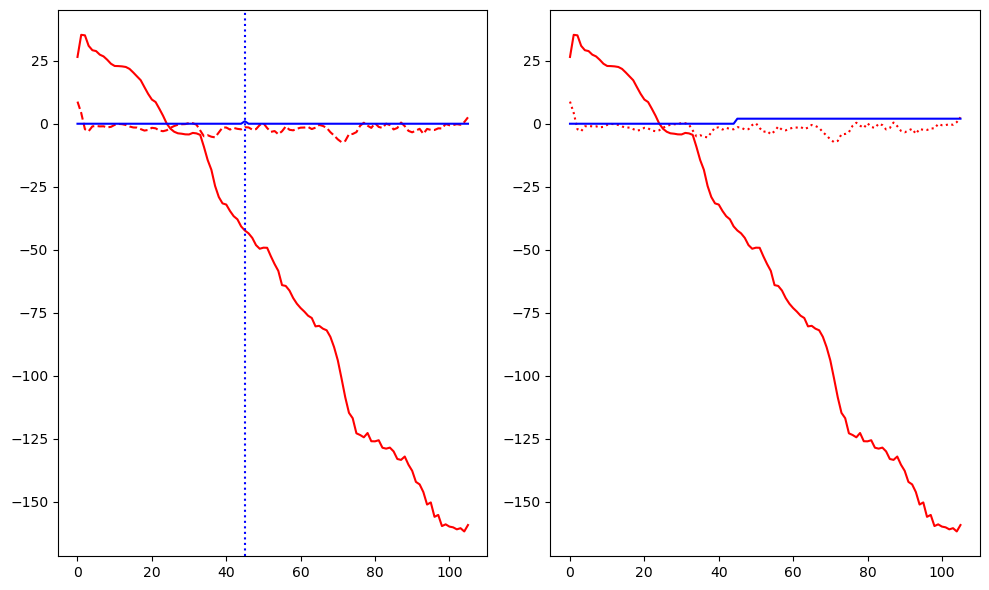

0.0


In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0] + val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 2

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

## Node states

In [18]:
node_states[0].shape

torch.Size([106, 100, 320])

In [20]:
nodes0 = node_states[0][-1]

pca4 = PCA(n_components=10)
X_red4 = pca4.fit_transform(nodes0)

In [21]:
node_label0 = node_labels[0][-1,:,0]

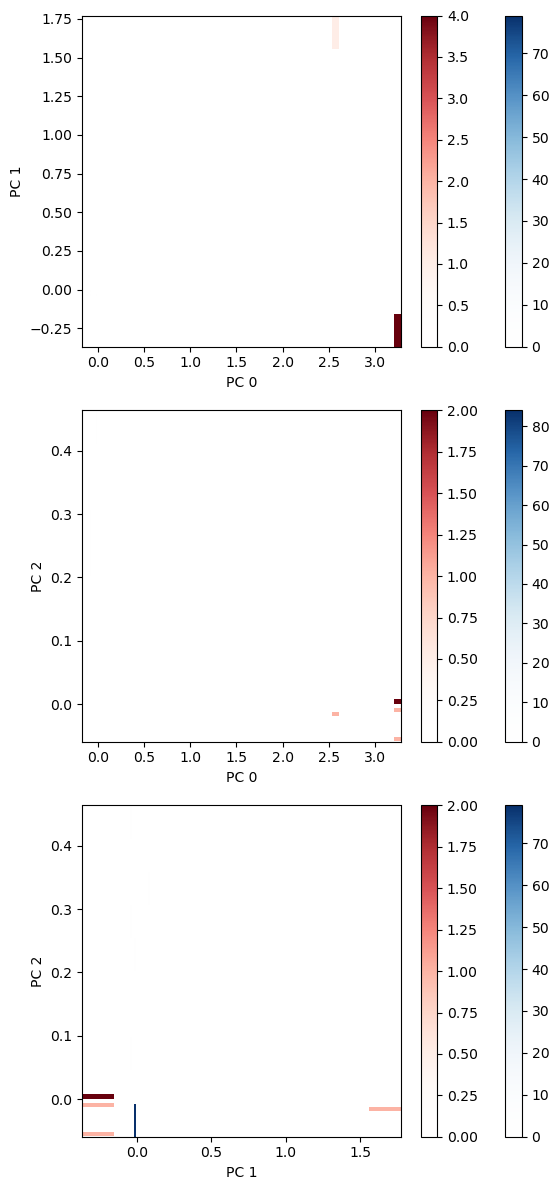

In [24]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

idx0 = node_label0 == 0
idx1 = node_label0 == 1
label_0 = X_red4[idx0]
label_1 = X_red4[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Calculate min and max values for each PC
pc0_min, pc0_max = min(X_red4[:, 0]), max(X_red4[:, 0])
pc1_min, pc1_max = min(X_red4[:, 1]), max(X_red4[:, 1])
pc2_min, pc2_max = min(X_red4[:, 2]), max(X_red4[:, 2])

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 1], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 1], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')
axs[0].set_xlim(pc0_min, pc0_max)
axs[0].set_ylim(pc1_min, pc1_max)
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 2')
axs[1].set_xlim(pc0_min, pc0_max)
axs[1].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 1], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 1], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 1')
axs[2].set_ylabel('PC 2')
axs[2].set_xlim(pc1_min, pc1_max)
axs[2].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [58]:
train_X.shape

(796, 106, 256)

In [59]:
node_states[0].shape

torch.Size([106, 100, 256])

In [27]:
from koopman.dmd import DMD

dim_red = 10
method = 'PCA'

g_idx = 20

# compute local Koopman operator
dmd = DMD(rearrange(node_states[g_idx], 't n f -> n t f'), k=dim_red, emb=method)

K0 = dmd.compute_KOP()

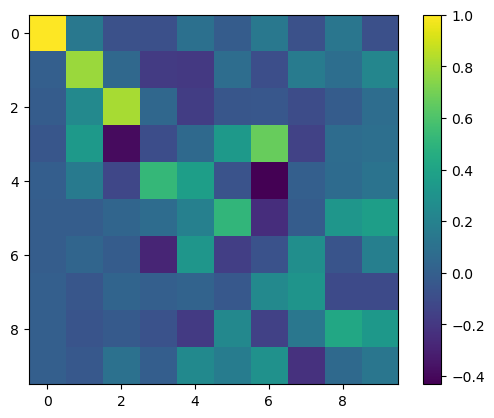

In [28]:
plt.imshow(K0)
plt.colorbar()

C:\Users\mgphy\AppData\Local\Temp\ipykernel_30604\1226691090.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



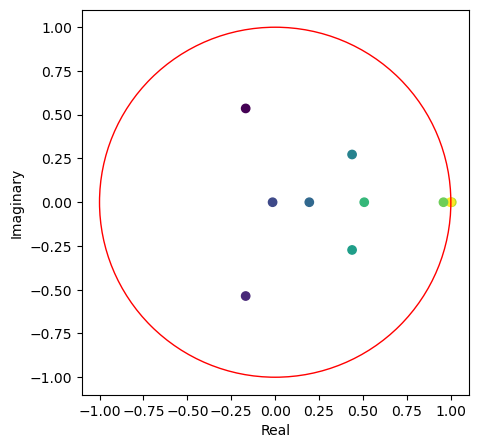

In [29]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

Distribution of eigenvalues for the two classes

In [31]:
from koopman.dmd import DMD
import seaborn as sns
import matplotlib

dim_red = 10
method = 'PCA'

node_states_1 = [node_states[i] for i in range(len(node_states)) if dataset.targets[i] == 1]

eigs_1 = np.empty((len(node_states_1), 2, dim_red))

for g in tqdm(range(len(node_states_1))):
    # compute local Koopman operator
    dmd = DMD(rearrange(node_states_1[g], 't n f -> n t f'), k=dim_red, emb=method)

    K = dmd.compute_KOP()

    E, _ = np.linalg.eig(K)

    # sort eigenvalues and eigenvectors
    idx = np.argsort(np.abs(E))[::-1]
    E = E[idx]

    eigs_1[g] = (E.real, E.imag)

node_states_0 = [node_states[i] for i in range(len(node_states)) if dataset.targets[i] == 0]

eigs_0 = np.empty((len(node_states_0), 2, dim_red))

for g in tqdm(range(len(node_states_0))):
    # compute local Koopman operator
    dmd = DMD(rearrange(node_states_0[g], 't n f -> n t f'), k=dim_red, emb=method)

    K = dmd.compute_KOP()

    E, _ = np.linalg.eig(K)

    # sort eigenvalues and eigenvectors
    idx = np.argsort(np.abs(E))[::-1]
    E = E[idx]

    eigs_0[g] = (E.real, E.imag)

100%|██████████| 497/497 [00:58<00:00,  8.46it/s]


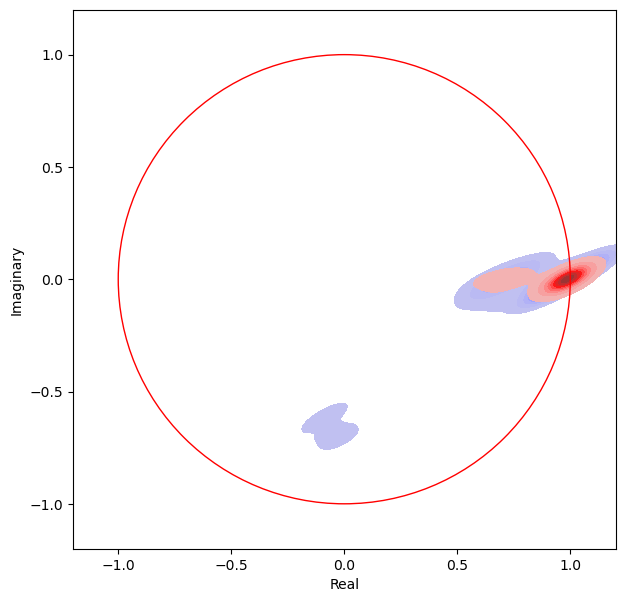

In [35]:

cmap = matplotlib.colormaps['viridis']

plt.figure(figsize=(7,7))
# plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
# for d in range(dim_red):
d = 1
sns.kdeplot(x=eigs_1[:,0,d], y=eigs_1[:,1,d], fill = True, color='b', label = "class 1")

sns.kdeplot(x=eigs_0[:,0,d], y=eigs_0[:,1,d], fill = True, color='r', label = "class 0")

circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()


In [36]:
from koopman.dmd import DMD

dim_red = 10
method = 'PCA'

g_idx = 20

# compute local Koopman operator
dmd = DMD(rearrange(node_states[g_idx], 't n f -> n t f'), k=dim_red, emb=method)

K0 = dmd.compute_KOP()
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

vr = V.real

# Calculate the projection
nodes_red0 = dmd.emb_engine.transform(rearrange(node_states[g_idx], 't n f -> (n t) f'))
nodes_red0 = rearrange(nodes_red0, '(n t) f -> n t f', n = node_states[g_idx].shape[1], t=node_states[g_idx].shape[0], f=dim_red)
nodes_proj0 = np.dot(nodes_red0, vr)

In [37]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")

995it [00:17, 56.23it/s]


In [67]:
times_gt[0].shape

torch.Size([106])

In [41]:
nodes_proj0[:,:,0][node_y.astype(bool)].shape

(11, 106)

In [43]:
np.where(node_y.astype(bool))

(array([ 6, 16, 35, 37, 76, 77, 78, 79, 80, 81, 91], dtype=int64),)

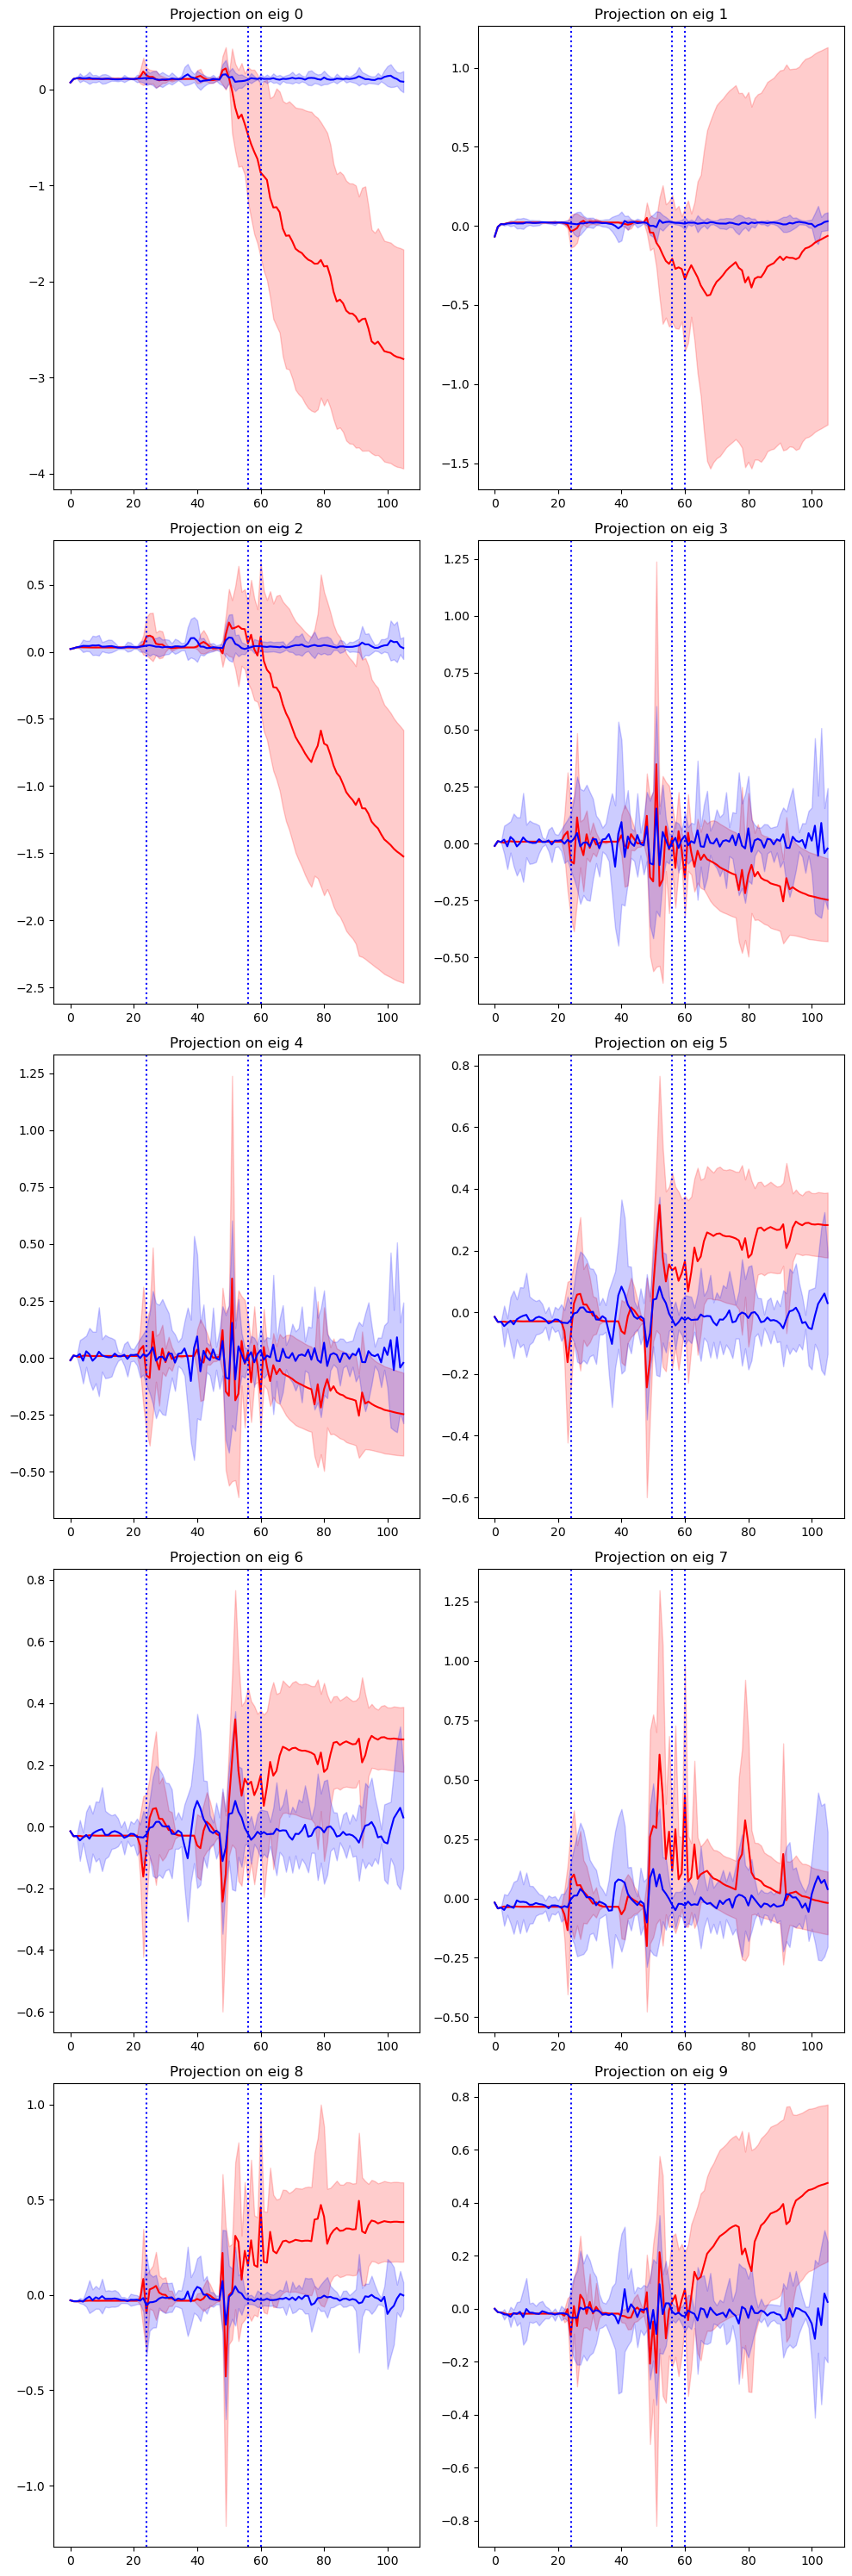

In [39]:
fig, axs = plt.subplots(5, 2, figsize=(10, 30))

node_y = node_labels[g_idx][-1,:,0].numpy()

for i in range(10):
    val_proj = nodes_proj0[:,:,i]

    m = val_proj[node_y.astype(bool)].mean(axis=0)
    s = val_proj[node_y.astype(bool)].std(axis=0)
    m_not = val_proj[~node_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~node_y.astype(bool)].std(axis=0)

    axs[i//2,i%2].plot(m, c='r', label="class 1")
    axs[i//2,i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2,i%2].plot(m_not, c='b', label="class 0")
    axs[i//2,i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2,i%2].set_title(f'Projection on eig {i}')

    idx_t = np.where(times_gt[0] != 0)[0]
    for j in idx_t:
        axs[i//2,i%2].axvline(x=j, color='b', linestyle='dotted')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

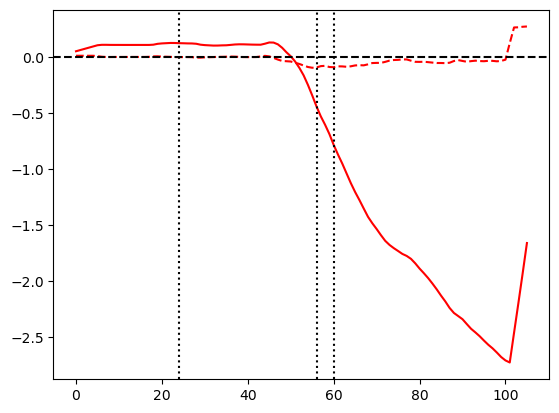

In [44]:
node_y = node_labels[g_idx][-1,:,0].numpy()

val_proj = nodes_proj0[:,:,0]

m = val_proj[node_y.astype(bool)].mean(axis=0)
m_not = val_proj[~node_y.astype(bool)].mean(axis=0)

m = np.convolve(m, np.ones(10)/10, mode='same')
der_m = np.gradient(m, axis=0)
# der_m_not = np.gradient(m_not, axis=0)

plt.plot(m, c='r', label="class 1")
plt.plot(der_m, c='r', linestyle='dashed', label="Derivative")
# plt.plot(m_not, c='b', label="class 0")
# plt.plot(der_m_not, c='b', linestyle='dashed', label="Derivative")

plt.axhline(y=0, color='black', linestyle='--')

idx_t = np.where(times_gt[0] != 0)[0]
for j in idx_t:
    plt.axvline(x=j, color='black', linestyle='dotted')

plt.show()

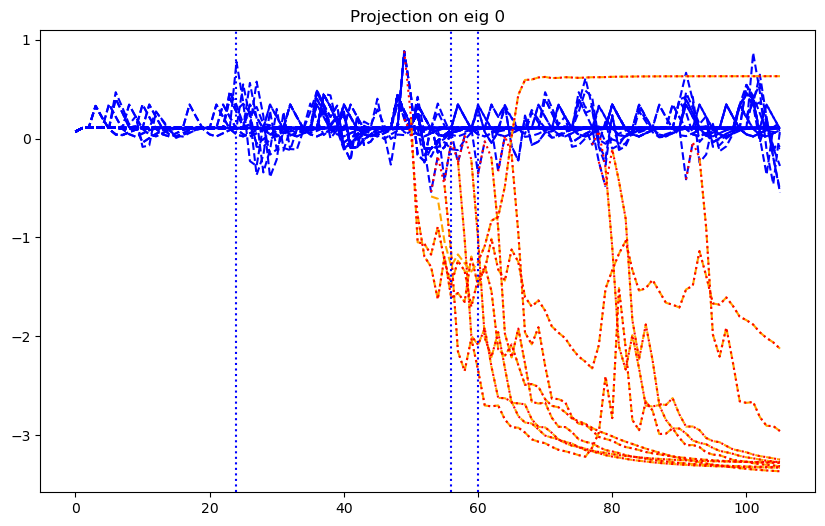

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

node_y = node_labels[g_idx][:,:,0].numpy().T

i=0

val_proj = nodes_proj0[:,:,i]

m = np.where(node_y.astype(bool), val_proj, np.NaN)
m_not = np.where(~node_y.astype(bool), val_proj, np.NaN)
m_gt = np.where((nodes_gt[g_idx].T != 0).numpy().astype(bool), val_proj, np.NaN)

for l in range(m_not.shape[0]):
    axs.plot(m_not[l], c='b', label="class 0", linestyle='dashed')
for n in range(m.shape[0]):
    axs.plot(m[n], c='orange', label="class 1", linestyle='dashed')
for k in range(m_gt.shape[0]):
    axs.plot(m_gt[k], c='r', label="GT", linestyle='dotted')
axs.set_title(f'Projection on eig {i}')

idx_t = np.where(times_gt[0] != 0)[0]
for j in idx_t:
    axs.axvline(x=j, color='b', linestyle='dotted')
    
# Show the plot
plt.show()